<a href="https://colab.research.google.com/github/anfins/Neural-Network/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using a Multi-Layer Perceptron to Predict March Madness 2023
Jorden Anfinson


Due to its 6-round tournament format with 64 teams, March Madness is notoriously difficult to predict accurately. Typically, forecasting March Madness entails using a model to predict the outcome of each game, in the hopes that the model will predict each one correctly. Building a model capable of doing so is considered next to impossible, and no model to this point has been able to do so. However, a more manageable task is to forecast the round in which each team will be eliminated. In this notebook, we explore the effectiveness of using a multi-layer perceptron to classify college basketball teams based on the round of March Madness in which they are eliminated. In doing so, we create a network that can accurately forecast the final placement of March Madness teams nearly 50 percent of the time, and find that Kansas, USC, Arizona, UCLA and Alabama have the best chance of winning the 2023 NCAA Tournament.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import cv2
import cv2 as cv
import pytest
import matplotlib.pyplot as plt
from sklearn import datasets   #only for the purposes of loading the iris dataset
import tensorflow as t
import numpy as np
from tensorflow import keras
# Set the random seed for numpy
np.random.seed(1)

# Set the random seed for TensorFlow
t.random.set_seed(1)


from google.colab import drive

from scipy import linalg as la


## Data Source



The data used in this notebook stems from a kaggle dataset hosted at the following URL:  https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset

It is also available in csv form at: https://raw.githubusercontent.com/anfins/Neural-Network/main/cbb.csv


The data in this dataset was originally scraped from the advanced college basketball statistics website "Barttorvik". It consists of each college basketball team's stats from 2013 to 2021, and of 24 features in total. Some of the features in the data include the team's name, home conference, resulting tournament seed and the year the team played. It additionally consists of more advanced statistics such as BARTHAG, which is a numeric representation of the percent chance that a given team would beat the average D1 basketball team.

We use the data from the 2013-2021 seasons to construct the neural network we  use to predict the final placement of 2023 College Basketball teams in March Madness. This data serves as our training data for the network.



In [ ]:
url = "https://raw.githubusercontent.com/anfins/Neural-Network/main/cbb.csv" #I stored the data on my github and connected it to the notebook
data = pd.read_csv(url, sep = ",")
data.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,Duke,ACC,39,35,125.2,90.6,0.9764,56.6,46.5,16.3,...,23.9,55.9,46.3,38.7,31.4,66.4,10.7,Champions,1.0,2015
1,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
2,Syracuse,ACC,37,23,111.9,93.6,0.8857,50.0,47.3,18.1,...,28.0,47.2,48.1,36.0,30.7,65.5,-0.3,F4,10.0,2016
3,Louisville,ACC,36,27,109.4,87.4,0.9290,47.7,44.0,17.2,...,33.3,48.4,43.3,30.7,30.3,65.6,5.8,E8,4.0,2015
4,North Carolina,ACC,38,26,119.6,92.5,0.9507,51.6,45.4,18.2,...,37.8,50.9,45.6,35.8,30.0,69.9,6.5,S16,4.0,2015


Because the dataset above lacks team data from the 2023 College Basketball season, we read in the data of College Basketball Teams **that made the 2023 March Madness Tournament** separately in the code below. For clarity, this data is referred to as "2023 Tournament Team Data" throughout the rest of this notebook. We later feed this data into the network we created by using the team data from 2013-2021 to predict the placement of these teams. This will serve as our final testing set for our network.

Note : While this paper was published after the culmination of the 2023 March Madness Touranment (congrats UConn!!), only team statistics from before the start of the tournament were used to construct the data. We also still include the team's seed, as that was assigned prior to the start of the tournament.

In [ ]:
url = "https://raw.githubusercontent.com/anfins/Neural-Network/main/CurrentCBB2.csv" #I stored the data on my github and connected it to the notebook
currentData = pd.read_csv(url, sep = ",") #reading in the data of teams from the 2023 season




In [ ]:
currentData.head() #note that the POSTSEASON column is left NaN to indicate these teams had not finished their season (still had yet to compete in March Madness)

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,Houston,Amer,34,31,117.1,88.0,0.9638,52.7,42.5,15.3,...,38.5,53.2,43.1,34.5,27.8,64.0,8.0,NaN,1.0,2023.0
1,Alabama,SEC,34,29,115.4,88.3,0.9557,52.7,41.5,19.0,...,32.8,54.6,41.2,33.8,28.1,73.5,10.2,NaN,1.0,2023.0
2,Creighton,BE,33,21,113.7,92.9,0.9112,54.3,47.3,16.6,...,19.8,54.5,45.6,36.0,34.1,69.9,10.0,NaN,6.0,2023.0
3,Connecticut,BE,33,25,118.8,92.5,0.9466,53.5,45.5,18.9,...,38.7,53.4,45.8,35.7,30.0,67.7,4.9,NaN,4.0,2023.0
4,San Diego St.,MWC,36,31,110.8,88.8,0.9276,49.6,46.3,17.4,...,29.4,49.0,49.4,33.9,27.8,65.7,5.7,NaN,5.0,2023.0


We then combine the team data from the 2013-2021 seasons with the team data from the 2023 season to make the data cleaning process the same for both groups of data.

In [ ]:
data = pd.concat([data, currentData]).reset_index() #combining the data (2013-2021 and 2023 Tournament Team Data Combined)

#### Data Cleaning


We clean the data by first filtering out teams that did not make the Tournament in their respective season from the training data. We do so because our final testing data only consists of teams we know to be in the 2023 March Madness tournament, so we are not interested in predicting whether or not a team will make the postseason or not (which would be a reason to include teams that did not make the Tournament in the training data).

In [ ]:
data['POSTSEASON'] = data['POSTSEASON'].fillna("NO POSTSEASON")
data= data.loc[(data["POSTSEASON"] != "NO POSTSEASON") | (data["YEAR"] == 2023)].reset_index() #we keep the data of 2023 tournament teams in the training data until after normalization
data = data.drop(["level_0"], axis = 1)

In [ ]:
data.head()

,index,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,0,Duke,ACC,39,35,125.2,90.6,0.9764,56.6,46.5,...,23.9,55.9,46.3,38.7,31.4,66.4,10.7,Champions,1.0,2015.0
1,1,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016.0
2,2,Syracuse,ACC,37,23,111.9,93.6,0.8857,50.0,47.3,...,28.0,47.2,48.1,36.0,30.7,65.5,-0.3,F4,10.0,2016.0
3,3,Louisville,ACC,36,27,109.4,87.4,0.9290,47.7,44.0,...,33.3,48.4,43.3,30.7,30.3,65.6,5.8,E8,4.0,2015.0
4,4,North Carolina,ACC,38,26,119.6,92.5,0.9507,51.6,45.4,...,37.8,50.9,45.6,35.8,30.0,69.9,6.5,S16,4.0,2015.0


In [ ]:
data['SEED'] = data['SEED'].fillna(0)


We then convert the columns "POSTSEASON" and "CONF" into numeric data so that they can be fed through the neural network.

In [ ]:
data["POSTSEASON"] = data["POSTSEASON"].astype(str) #converting to string

In [ ]:
data["PostseasonNums"] = 0  #the code below converts the values in the "POSTSEASON" column, to numeric values in the "PostseasonNums" column
for row,rowSeries in data.iterrows():

  if(rowSeries["POSTSEASON"] == "Champions"):
    data.at[row, "PostseasonNums"] = 0

  elif(rowSeries["POSTSEASON"] == "2ND"):
    data.at[row, "PostseasonNums"] = 1

  elif(rowSeries["POSTSEASON"] == "F4"):
    data.at[row, "PostseasonNums"] = 2

  elif(rowSeries["POSTSEASON"] == "E8"):
    data.at[row, "PostseasonNums"] = 3

  elif(rowSeries["POSTSEASON"] == "S16"):
    data.at[row, "PostseasonNums"] = 4

  elif(rowSeries["POSTSEASON"] == "R32"):
    data.at[row, "PostseasonNums"] = 5

  elif(rowSeries["POSTSEASON"] == "R64"):
    data.at[row, "PostseasonNums"] = 6

  elif(rowSeries["POSTSEASON"] == "R68"):
    data.at[row, "PostseasonNums"] = 7
  else:
    data.at[row, "PostseasonNums"] = 8


In [ ]:
classNames = ["Champions", "Runners Up", "Final 4", "Elite 8", "Sweet 16", "Round of 32", "Round of 64", "Round of 68", "NA"]

In [ ]:
data["CONF"] = pd.Categorical(data["CONF"])
data["CONFB"] = data["CONF"].cat.codes

In [ ]:
data = data.drop(["index"], axis = 1)

The result of these changes can be seen below.

In [ ]:
data

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,PostseasonNums,CONFB
0,Duke,ACC,39,35,125.2,90.6,0.9764,56.6,46.5,16.3,...,46.3,38.7,31.4,66.4,10.7,Champions,1.0,2015.0,0,1
1,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016.0,1,1
2,Syracuse,ACC,37,23,111.9,93.6,0.8857,50.0,47.3,18.1,...,48.1,36.0,30.7,65.5,-0.3,F4,10.0,2016.0,2,1
3,Louisville,ACC,36,27,109.4,87.4,0.9290,47.7,44.0,17.2,...,43.3,30.7,30.3,65.6,5.8,E8,4.0,2015.0,3,1
4,North Carolina,ACC,38,26,119.6,92.5,0.9507,51.6,45.4,18.2,...,45.6,35.8,30.0,69.9,6.5,S16,4.0,2015.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,UNC Asheville,Bsth,32,25,101.2,102.4,0.4668,53.9,48.0,20.0,...,49.1,38.8,30.5,69.1,-1.9,NO POSTSEASON,16.0,2023.0,8,14
543,Texas A&M Corpus Chris,SInd,30,20,104.3,106.0,0.4540,50.9,52.4,18.0,...,54.3,36.5,33.2,69.8,-6.0,NO POSTSEASON,16.0,2023.0,8,31
544,Howard,MEAC,31,19,100.9,105.7,0.3695,52.0,50.6,22.8,...,50.8,37.2,33.6,69.7,-7.3,NO POSTSEASON,16.0,2023.0,8,21
545,Southeast Missouri St.,OVC,34,17,98.6,106.8,0.2856,50.1,51.3,17.3,...,50.7,33.2,35.0,72.8,-11.7,NO POSTSEASON,16.0,2023.0,8,25


We then reseparate the data, 2023 Tournament Teams (final testing data) go into the dataframe "currentTournamentTeams" and 2013-2021 Tournament teams go into the dataframe "data". We do so because we must use the mean and standard deviation of our training set to normalize our testing data, and in order to calculate those values our training set must be kept separate from our final testing data.

In [ ]:
currentTournamentTeams = data[data["YEAR"] == 2023].reset_index()
data = data[data["YEAR"] != 2023].reset_index()

In [ ]:
currentTournamentTeams

,index,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,...,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,PostseasonNums,CONFB
0,480,Houston,Amer,34,31,117.1,88.0,0.9638,52.7,42.5,...,43.1,34.5,27.8,64.0,8.0,NO POSTSEASON,1.0,2023.0,8,4
1,481,Alabama,SEC,34,29,115.4,88.3,0.9557,52.7,41.5,...,41.2,33.8,28.1,73.5,10.2,NO POSTSEASON,1.0,2023.0,8,30
2,482,Creighton,BE,33,21,113.7,92.9,0.9112,54.3,47.3,...,45.6,36.0,34.1,69.9,10.0,NO POSTSEASON,6.0,2023.0,8,9
3,483,Connecticut,BE,33,25,118.8,92.5,0.9466,53.5,45.5,...,45.8,35.7,30.0,67.7,4.9,NO POSTSEASON,4.0,2023.0,8,9
4,484,San Diego St.,MWC,36,31,110.8,88.8,0.9276,49.6,46.3,...,49.4,33.9,27.8,65.7,5.7,NO POSTSEASON,5.0,2023.0,8,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,542,UNC Asheville,Bsth,32,25,101.2,102.4,0.4668,53.9,48.0,...,49.1,38.8,30.5,69.1,-1.9,NO POSTSEASON,16.0,2023.0,8,14
63,543,Texas A&M Corpus Chris,SInd,30,20,104.3,106.0,0.4540,50.9,52.4,...,54.3,36.5,33.2,69.8,-6.0,NO POSTSEASON,16.0,2023.0,8,31
64,544,Howard,MEAC,31,19,100.9,105.7,0.3695,52.0,50.6,...,50.8,37.2,33.6,69.7,-7.3,NO POSTSEASON,16.0,2023.0,8,21
65,545,Southeast Missouri St.,OVC,34,17,98.6,106.8,0.2856,50.1,51.3,...,50.7,33.2,35.0,72.8,-11.7,NO POSTSEASON,16.0,2023.0,8,25


### Normalizing the Data


Normalizing the input values is an essential task to complete before training a network. Feeding inputs of different scales through the network is inefficient, as the weight adjustments caused by input values of one scale might not be optimal for values of another scale. This means that more training data will have to be fed through the model to reach the optimal weights for the model. However, if the input values are normalized before feeding them through the network, the weight changes made for one input will be applicable to all inputs, meaning that the network will reach its optimal weights quicker than if inputs of differing scales are fed through the model.


To prevent issues with normalization, we remove certain columns from the data, such as those containing string data (e.g., team names). Additionally, we remove the columns "G" and "W" because 2023 Tournament Teams will not have played as many games as teams from 2013-2021 because they have yet to complete their season. Before removing them, we make copies of the data so that we can reattach them later. Furthermore, we exclude the "postseasonNums" column from the data as we don't want to normalize our response variable. We also create a copy of its values beforehand.


In [ ]:
postseasonResults = []
years = []
seeds = []
teams = []
for row, rowSeries in data.iterrows(): #making copies of certain feature values before dropping them from the dataframe
  postseasonResults.append(rowSeries["PostseasonNums"])
  years.append(rowSeries["YEAR"])
  seeds.append(rowSeries["SEED"])
  teams.append(rowSeries["TEAM"])
refined = data.drop(["G", "W", "TEAM", "CONF", "POSTSEASON","YEAR", "PostseasonNums", "CONFB"], axis =1) #dropping columns that do not need normalized from the data

refinedMean = refined.mean()

refinedStd = refined.std()


normalizedRefined=(refined-refined.mean())/refined.std()  #normalizing the data





currentYears = []
currentSeeds = []
currentTeams = []
for row, rowSeries in currentTournamentTeams.iterrows(): #making copies of certain feature values before dropping them from the dataframe
  currentYears.append(rowSeries["YEAR"])
  currentSeeds.append(rowSeries["SEED"])
  currentTeams.append(rowSeries["TEAM"])

refinedFinalTesting = currentTournamentTeams.drop(["G", "W","TEAM", "CONF", "POSTSEASON","YEAR", "PostseasonNums", "CONFB"], axis =1) #dropping columns that do not need normalized from the data

normalizedFinalTesting = refinedFinalTesting.sub(refinedMean)
normalizedFinalTesting= normalizedFinalTesting.div(refinedStd)



normalizedRefined.head(10)


,index,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED
0,-1.726645,2.146791,-1.115185,1.058822,1.658192,-0.487976,-0.660001,-0.182633,0.958021,0.404368,0.496310,-1.637261,1.624001,-0.101587,1.092349,-0.853074,-0.375475,1.855472,-1.668541
1,-1.719435,1.848148,-0.320494,0.921394,0.187444,0.167667,-1.148806,-0.349930,2.120697,0.335171,-0.901637,-0.529276,0.947422,-0.671703,-1.268069,1.468820,1.273425,1.435138,-1.668541
2,-1.712226,0.056290,-0.560750,0.523855,-0.768542,-0.160154,0.317610,0.570205,0.412275,2.168880,-0.323819,-0.938378,-1.319117,0.502065,0.030161,-1.191684,-0.655477,-0.346275,0.259273
3,-1.705017,-0.336661,-1.706583,0.779247,-1.614222,-1.512418,-0.171195,0.946625,0.697012,0.611957,0.291278,-0.034944,-0.913170,-1.107673,-2.054874,-1.385175,-0.624365,0.874694,-1.025937
4,-1.697807,1.266580,-0.764043,0.907238,-0.180243,-0.938730,0.371922,-0.559052,1.954600,0.750350,-0.361097,0.732122,-0.067446,-0.336340,-0.048520,-1.530294,0.713421,1.014805,-1.025937
5,-1.690598,-0.713894,-0.394419,0.053178,0.297750,-0.160154,0.208987,0.862976,-2.007989,-0.218402,2.043371,-0.495184,0.507646,-0.034514,-0.127200,-0.320974,-1.184369,-0.126100,0.473475
6,-1.683388,1.062246,1.028632,0.274951,1.216967,0.659399,-1.854859,-0.851823,-0.513120,0.473564,-1.609930,0.186653,0.676790,1.608761,1.092349,-1.530294,-0.126584,0.054043,0.259273
7,-1.676179,1.706686,1.102556,0.508520,0.738974,2.052640,-0.605689,-1.186418,-0.252111,-0.460590,0.664064,0.766214,0.338501,1.843514,1.013668,1.275329,1.366759,-0.026021,0.473475
8,-1.668970,2.759795,-0.560750,1.055283,0.996355,0.003756,-2.778158,-1.353715,0.080082,-1.844521,-0.174705,-1.892950,1.251882,-0.638166,0.226862,2.097666,-2.584378,1.975567,-1.668541
9,-1.661760,0.449242,-1.152147,0.829382,0.665437,0.003756,-1.909170,0.193786,-1.485971,-1.429342,-1.199865,-0.597460,1.218053,0.066094,-0.284561,0.017636,-0.531031,1.094869,-1.240138


In [ ]:
normalizedFinalTesting.head(10)

,index,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED
0,1.733854,0.873629,-1.595696,0.984505,0.224212,-2.127083,-1.203118,1.239395,1.266486,-0.564385,-1.609930,0.851444,0.710619,-1.174746,-0.559943,-2.594495,-1.122146,1.315043,-1.668541
1,1.741063,0.606422,-1.540252,0.936729,0.224212,-2.536860,0.806416,-1.311891,0.483460,-0.529786,-0.081508,-0.120174,1.184224,-1.811934,-0.835325,-2.449377,1.833429,1.755393,-1.668541
2,1.748273,0.339215,-0.690118,0.674259,0.812512,-0.160154,-0.497065,-1.981080,-1.485971,-1.982915,-1.684487,-2.336144,1.150395,-0.336340,0.030161,0.452991,0.713421,1.715361,-0.597533
3,1.755482,1.140836,-0.764043,0.883056,0.518362,-0.897753,0.752104,0.151962,1.764776,-0.979564,-1.069390,0.885536,0.778277,-0.269268,-0.087860,-1.530294,0.028972,0.694551,-1.025937
4,1.762692,-0.116608,-1.447846,0.770990,-0.915617,-0.569931,-0.062572,0.068313,-0.014830,-1.083359,-0.752523,-0.699735,-0.710196,0.938036,-0.795985,-2.594495,-0.593254,0.854678,-0.811735
5,1.769901,0.999373,-0.542269,0.804020,-0.106706,-0.201132,-0.171195,-1.521012,1.574951,-1.913718,0.011688,-2.438419,1.015080,0.200239,-1.464770,-0.901447,-1.153258,1.595266,-1.668541
6,1.777110,1.235144,-0.228089,0.781607,1.621423,-0.242110,0.480546,-0.893647,-0.252111,-1.014162,-0.249262,-1.364526,1.793145,-0.135123,0.738286,-0.417719,1.428982,1.234980,-1.454340
7,1.784320,0.889347,0.160016,0.566912,-0.217012,1.315042,0.534857,0.779327,0.530916,0.092983,0.421753,0.885536,-0.067446,1.407543,-0.363242,0.404618,0.246752,-0.006005,0.045072
8,1.791529,0.103444,-0.338976,0.451307,1.069893,-0.733842,-0.442754,-0.308106,-0.323295,-1.567735,-1.423537,-1.159975,1.082738,-0.604630,0.502244,-0.562838,0.402308,0.654519,0.045072
9,1.798738,-0.619586,0.917744,-0.810908,0.150675,0.126689,-0.334130,-1.897432,-0.797857,-2.155906,-0.901637,-0.716781,0.812106,0.200239,-0.756645,-0.030737,0.153418,-0.926735,1.330281


The code below reappends the postseason results of the teams in our training data, so that it can be used as an output variables for our network.

In [ ]:
normalizedRefined["PostseasonResults"] = 0
for i in range(0, len(postseasonResults)):
  normalizedRefined.at[i,"PostseasonResults"] = postseasonResults[i]
normalizedRefined = normalizedRefined.drop(["index"], axis=1)

In [ ]:
normalizedRefined

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,PostseasonResults
0,2.146791,-1.115185,1.058822,1.658192,-0.487976,-0.660001,-0.182633,0.958021,0.404368,0.496310,-1.637261,1.624001,-0.101587,1.092349,-0.853074,-0.375475,1.855472,-1.668541,0
1,1.848148,-0.320494,0.921394,0.187444,0.167667,-1.148806,-0.349930,2.120697,0.335171,-0.901637,-0.529276,0.947422,-0.671703,-1.268069,1.468820,1.273425,1.435138,-1.668541,1
2,0.056290,-0.560750,0.523855,-0.768542,-0.160154,0.317610,0.570205,0.412275,2.168880,-0.323819,-0.938378,-1.319117,0.502065,0.030161,-1.191684,-0.655477,-0.346275,0.259273,2
3,-0.336661,-1.706583,0.779247,-1.614222,-1.512418,-0.171195,0.946625,0.697012,0.611957,0.291278,-0.034944,-0.913170,-1.107673,-2.054874,-1.385175,-0.624365,0.874694,-1.025937,3
4,1.266580,-0.764043,0.907238,-0.180243,-0.938730,0.371922,-0.559052,1.954600,0.750350,-0.361097,0.732122,-0.067446,-0.336340,-0.048520,-1.530294,0.713421,1.014805,-1.025937,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-0.022300,-1.632658,0.839409,-0.547930,-1.307529,1.784027,0.068313,1.029205,-0.495188,-0.100147,-0.188357,-0.236591,-0.772311,-0.717305,-1.481921,-0.997701,1.054837,-1.240138,4
476,0.449242,-0.819486,0.743268,0.150675,-0.446998,1.077975,0.319259,0.768197,-0.806573,0.048967,-0.103128,-0.168933,-1.074137,0.462904,1.275329,-0.251029,0.634503,-0.597533,4
477,-1.059691,-1.484809,0.447768,-1.025923,-0.528954,2.109897,1.239395,0.958021,-0.633581,0.235360,-0.034944,-0.676367,-0.571094,-1.032027,0.114382,0.495642,0.294233,0.687676,4
478,0.072008,-0.080239,0.322726,-0.069937,0.659399,-0.225507,0.946625,-0.655488,1.788299,-1.088030,-0.853148,-0.608709,1.340471,0.698946,-1.433548,-0.499920,-0.226179,0.901878,4


### Splitting the Data

We now split the data into a training, validation and testing set. 60% of Tournament Team Data from 2013-2021 will be fed into the training set, 20% will be fed into the validation set and 20% will be fed into the testing set.

We utilize a validation set to help prevent our network from overfitting the training data. If the network were to overlearn the training data, it would not be able to generalize and accurately predict data it had never been faced with before.

In [ ]:
def splitData(data, testingPercentage, validationPercentage):
    '''
    This function splits inputted data into three separate datasets, each of which are returned.
    It takes 3 inputs:
      data : the data one wishes to be split
      testingPercentage : the percentage of the original data one wants to be allocated for testing
      validationPercentage : the percentage of the original data one wants to be allocated for validation
    The function will return three separate datasets, one for the training data, one for the testing and one for the validation
    '''

    shuffled_indices = np.random.permutation(len(data)) #randomly arranges the observations within the data
    test_set_size = int(len(data)*testingPercentage) #calculates the number of observations needed to create a proper testing set
    validation_set_size = int(len(data)*validationPercentage)
    training_set_size = len(data)-test_set_size - validation_set_size
    train_indices = shuffled_indices[:training_set_size] #allocates the testing and training indices
    validation_indices = shuffled_indices[training_set_size:training_set_size+validation_set_size]
    test_indices = shuffled_indices[training_set_size+validation_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices],data.iloc[validation_indices]  #training, testing, validation datasets are returned (in that order)


In [ ]:
training, testing, validation = splitData(normalizedRefined, 0.20, 0.20) #creates 3 new datasets, one for training, one for testing and one for validation


In [ ]:
trainingX = training.drop(["PostseasonResults"], axis = 1)
trainingY = training[["PostseasonResults"]]
validationX = validation.drop(["PostseasonResults"], axis = 1)
validationY = validation[["PostseasonResults"]]
testingX = testing.drop(["PostseasonResults"], axis = 1)
testingY = testing[["PostseasonResults"]]

In [ ]:
trainingX.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED
293,0.857911,0.695970,0.329804,1.547886,0.905265,-0.008260,-0.977296,0.341091,-1.360145,-0.044229,-0.392909,1.894632,0.367920,0.384223,1.275329,0.215640,0.474376,-1.025937
283,-0.446687,1.878766,-1.457941,1.621423,1.478953,1.512468,-0.224457,-0.679216,0.196778,-0.920276,-0.904286,1.793145,1.541688,0.698946,0.549737,-0.002139,-1.226973,1.330281
34,1.077964,-0.080239,0.704340,0.077138,0.495488,-0.768624,0.486557,0.554644,0.508162,0.589506,-0.256541,0.507646,-0.168659,-0.599284,1.468820,0.433420,1.054837,-1.668541
380,-1.075409,-0.653156,-0.019369,-0.915617,-2.127083,-1.311741,-2.064729,-0.584304,-1.636932,-0.267901,-0.699735,-0.946999,-1.845470,-0.048520,-1.288430,-1.308814,-0.086068,0.473475
430,0.024854,-1.059742,0.694313,-0.584699,-0.201132,0.752104,0.528381,0.246179,-0.702778,-0.249262,0.374158,-0.067446,-0.436949,-1.071367,0.162754,0.744533,1.234980,-1.025937


## Construction of the MLP

We construct the MLP using an input layer, two hidden layers, and an output layer.



*   Input Layer
  *   Made up of 18 nodes for each of the training data's features

*   First Hidden Layer
  *   Made up of 26 nodes that use the relu function to determine if they activate or not
*   Second Hidden Layer
  *   Made up of 18 nodes that also use the relu function to determine if they activate
*   Output layer
  *   Made up of 8 output nodes (one for each possible tournament outcome). The possible outcomes are listed below. Uses the soft-max activation function to compute the chance an observation belongs to each of the 8 possible outcomes listed below.
    *  Round of 68, Round of 64, Round of 32, Sweet 16, Elite 8, Final 4, Runner Up, Champion












In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(18, input_dim=18, activation='relu'))
model.add(keras.layers.Dense(36, activation = "relu"))
model.add(keras.layers.Dense(18, activation = "relu"))
model.add(keras.layers.Dense(8, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "sgd", metrics = ["accuracy"])

In order to determine when we need to stop training the model, we first train it an excessive number of times. In doing so we can see the point at which the validation loss begins to increase. Using the graph below as an aid, we can see that the validation loss begins to increase at around epoch 120.

In [ ]:
history = model.fit(trainingX, trainingY, epochs = 400, validation_data = (validationX, validationY))

Epoch 1/400
9/9 [==============================] - 2s 56ms/step - loss: 1.9610 - accuracy: 0.1944 - val_loss: 1.9542 - val_accuracy: 0.2708
Epoch 2/400
9/9 [==============================] - 0s 15ms/step - loss: 1.8937 - accuracy: 0.3229 - val_loss: 1.8849 - val_accuracy: 0.3958
Epoch 3/400
9/9 [==============================] - 0s 9ms/step - loss: 1.8350 - accuracy: 0.3681 - val_loss: 1.8234 - val_accuracy: 0.4792
Epoch 4/400
9/9 [==============================] - 0s 10ms/step - loss: 1.7860 - accuracy: 0.4028 - val_loss: 1.7713 - val_accuracy: 0.5104
Epoch 5/400
9/9 [==============================] - 0s 12ms/step - loss: 1.7447 - accuracy: 0.4271 - val_loss: 1.7268 - val_accuracy: 0.5417
Epoch 6/400
9/9 [==============================] - 0s 19ms/step - loss: 1.7105 - accuracy: 0.4306 - val_loss: 1.6888 - val_accuracy: 0.5417
Epoch 7/400
9/9 [==============================] - 0s 10ms/step - loss: 1.6816 - accuracy: 0.4410 - val_loss: 1.6575 - val_accuracy: 0.5417
Epoch 8/400
9/9 [====

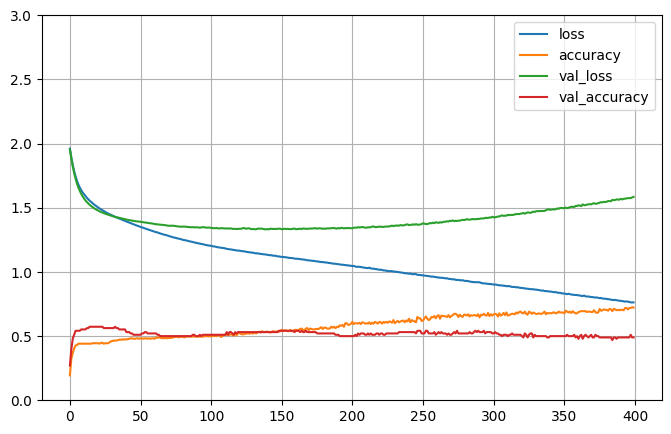

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,3)
plt.show()

### Retraining the Model

We saw that the validation loss began to increase at around training step 120. Training the network additional times would overfit the network to the training data. Thus, we retrain the model, this time only training it around 120 times to avoid overfitting.

In [ ]:
np.random.seed(0)
t.random.set_seed(0)

model = keras.models.Sequential()
model.add(keras.layers.Dense(18, input_dim=18, activation='relu'))
model.add(keras.layers.Dense(36, activation = "relu"))
model.add(keras.layers.Dense(18, activation = "relu"))
model.add(keras.layers.Dense(8, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history = model.fit(trainingX, trainingY, epochs = 120, validation_data = (validationX, validationY))

Epoch 1/120
9/9 [==============================] - 1s 32ms/step - loss: 1.9802 - accuracy: 0.3681 - val_loss: 1.9105 - val_accuracy: 0.5417
Epoch 2/120
9/9 [==============================] - 0s 7ms/step - loss: 1.9290 - accuracy: 0.4201 - val_loss: 1.8575 - val_accuracy: 0.5104
Epoch 3/120
9/9 [==============================] - 0s 6ms/step - loss: 1.8814 - accuracy: 0.4306 - val_loss: 1.8077 - val_accuracy: 0.5312
Epoch 4/120
9/9 [==============================] - 0s 7ms/step - loss: 1.8386 - accuracy: 0.4306 - val_loss: 1.7623 - val_accuracy: 0.5417
Epoch 5/120
9/9 [==============================] - 0s 8ms/step - loss: 1.8005 - accuracy: 0.4340 - val_loss: 1.7218 - val_accuracy: 0.5417
Epoch 6/120
9/9 [==============================] - 0s 5ms/step - loss: 1.7677 - accuracy: 0.4410 - val_loss: 1.6870 - val_accuracy: 0.5417
Epoch 7/120
9/9 [==============================] - 0s 5ms/step - loss: 1.7398 - accuracy: 0.4410 - val_loss: 1.6572 - val_accuracy: 0.5417
Epoch 8/120
9/9 [=========

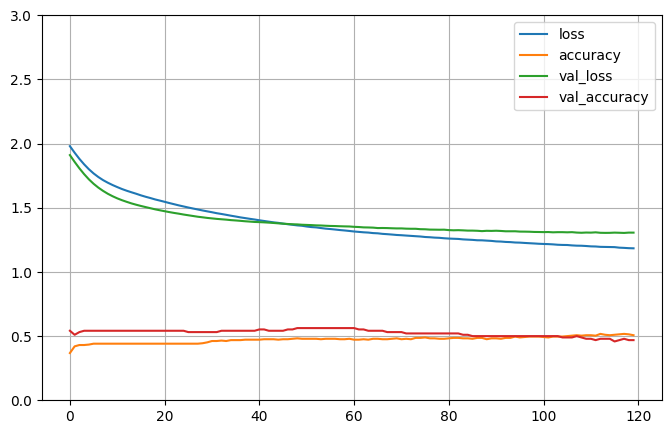

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,3)
plt.show()

After approximately 40 training steps, the network achieves a validation accuracy of just above 50%. This indicates that the network accurately categorizes teams in the validation set based on the round of March Madness in which they are eliminated approximately 60% of the time. The network does not improve much after this point.

# Predicting Using Current Season Data

Using the network above, we predict the tournament results of the 2023 Tournament teams. As a refresher the data of these teams is presented below.

In [ ]:
currentTournamentTeams.drop(["POSTSEASON"], axis =1)

,index,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,YEAR,PostseasonNums,CONFB
0,480,Houston,Amer,34,31,117.1,88.0,0.9638,52.7,42.5,...,53.2,43.1,34.5,27.8,64.0,8.0,1.0,2023.0,8,4
1,481,Alabama,SEC,34,29,115.4,88.3,0.9557,52.7,41.5,...,54.6,41.2,33.8,28.1,73.5,10.2,1.0,2023.0,8,30
2,482,Creighton,BE,33,21,113.7,92.9,0.9112,54.3,47.3,...,54.5,45.6,36.0,34.1,69.9,10.0,6.0,2023.0,8,9
3,483,Connecticut,BE,33,25,118.8,92.5,0.9466,53.5,45.5,...,53.4,45.8,35.7,30.0,67.7,4.9,4.0,2023.0,8,9
4,484,San Diego St.,MWC,36,31,110.8,88.8,0.9276,49.6,46.3,...,49.0,49.4,33.9,27.8,65.7,5.7,5.0,2023.0,8,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,542,UNC Asheville,Bsth,32,25,101.2,102.4,0.4668,53.9,48.0,...,51.4,49.1,38.8,30.5,69.1,-1.9,16.0,2023.0,8,14
63,543,Texas A&M Corpus Chris,SInd,30,20,104.3,106.0,0.4540,50.9,52.4,...,48.9,54.3,36.5,33.2,69.8,-6.0,16.0,2023.0,8,31
64,544,Howard,MEAC,31,19,100.9,105.7,0.3695,52.0,50.6,...,49.9,50.8,37.2,33.6,69.7,-7.3,16.0,2023.0,8,21
65,545,Southeast Missouri St.,OVC,34,17,98.6,106.8,0.2856,50.1,51.3,...,50.3,50.7,33.2,35.0,72.8,-11.7,16.0,2023.0,8,25


Here is the normalized and refined version of that data

In [ ]:
normalizedFinalTesting = normalizedFinalTesting.drop(["index"],axis =1)

In [ ]:
predictions = model.predict(normalizedFinalTesting)
predicted_classes = np.argmax(predictions, axis=1)


predictionDf = pd.DataFrame((predictions * 100), columns = ["Champion", "Runner Up", "Final 4", "Elite 8", "Sweet 16", "Round of 32", "Round of 64", "Round of 68"])
predictionDf["Team"] = ""

for row, rowSeries in predictionDf.iterrows():
  predictionDf.at[row, "Team"] = currentTeams[row]


predictionDf

3/3 [==============================] - 0s 4ms/step


,Champion,Runner Up,Final 4,Elite 8,Sweet 16,Round of 32,Round of 64,Round of 68,Team
0,4.308848e+00,1.770895,4.262580,14.581471,24.333672,33.919193,14.501762,2.321578,Houston
1,5.353984e+00,1.929349,3.517991,16.237791,26.200974,31.666740,13.669114,1.424062,Alabama
2,3.632420e+00,1.664329,3.030068,8.380038,24.500967,34.123489,23.162910,1.505769,Creighton
3,2.872478e+00,2.049285,3.199738,8.585908,26.403105,33.833546,20.431007,2.624929,Connecticut
4,7.385253e-01,0.742036,1.897917,1.631406,12.376484,42.588512,36.178391,3.846724,San Diego St.
...,...,...,...,...,...,...,...,...,...
62,1.707078e-03,0.042685,0.174508,0.008465,1.625739,7.744429,75.520638,14.881827,UNC Asheville
63,1.897237e-04,0.013020,0.084716,0.001630,0.493378,5.292445,60.843647,33.270977,Texas A&M Corpus Chris
64,7.307514e-06,0.002369,0.012359,0.000080,0.152753,1.983950,60.553211,37.295273,Howard
65,1.403862e-05,0.001955,0.016787,0.000170,0.238535,3.371224,77.720390,18.650928,Southeast Missouri St.


In [ ]:
predictionDf["Predicted Outcome"] = ""
for i in range(0 ,len(predicted_classes)):
  predictionDf.at[i, "Predicted Outcome"] = classNames[predicted_classes[i]]

The ten teams given the best chance to win the 2023 March Madness tournament are shown in the table below.

In [ ]:
predictionDf.sort_values(["Champion"], ascending = False).head(10)

,Champion,Runner Up,Final 4,Elite 8,Sweet 16,Round of 32,Round of 64,Round of 68,Team,Predicted Outcome
20,7.282208,2.380068,4.396314,20.252773,25.479477,27.633974,10.758170,1.817013,Kansas,Round of 32
17,5.872602,1.982180,3.262717,13.318756,19.787130,38.883602,15.291934,1.601084,UCLA,Round of 32
6,5.548048,2.676168,4.335838,14.238079,33.629230,24.676640,12.945925,1.950067,Arizona,Sweet 16
40,5.378686,3.715355,5.537641,10.295542,21.690481,29.547552,20.021872,3.812864,USC,Round of 32
1,5.353984,1.929349,3.517991,16.237791,26.200974,31.666740,13.669114,1.424062,Alabama,Round of 32
22,5.111673,4.858502,5.474943,8.879020,26.895485,24.218702,20.135168,4.426504,Memphis,Sweet 16
32,5.036636,2.836027,5.058550,11.711785,25.115517,28.651455,18.526407,3.063615,Indiana,Round of 32
16,4.910217,1.751992,3.885348,15.981007,28.670534,30.550829,12.120568,2.129492,Texas,Round of 32
5,4.652938,3.743341,2.972783,8.155657,17.735901,36.394302,23.900826,2.444260,Purdue,Round of 32
0,4.308848,1.770895,4.262580,14.581471,24.333672,33.919193,14.501762,2.321578,Houston,Round of 32


The predicted tournament outcomes for each 2023 Tournament Team are shown below.

In [ ]:
for row, rowSeries in predictionDf.iterrows():
  print(rowSeries["Team"], ":", rowSeries["Predicted Outcome"])

Houston : Round of 32
Alabama : Round of 32
Creighton : Round of 32
Connecticut : Round of 32
San Diego St. : Round of 32
Purdue : Round of 32
Arizona : Sweet 16
West Virginia : Round of 64
Florida Atlantic : Round of 64
Princeton : Round of 64
Miami FL : Round of 64
Virginia : Round of 32
TCU : Round of 64
Kansas St. : Round of 32
Marquette : Sweet 16
Gonzaga : Round of 64
Texas : Round of 32
UCLA : Round of 32
Tennessee : Round of 32
Saint Mary's : Round of 32
Kansas : Round of 32
Baylor : Round of 64
Memphis : Sweet 16
Arkansas : Round of 64
Xavier : Round of 64
Auburn : Round of 64
Iowa St. : Round of 32
Duke : Round of 32
Texas A&M : Round of 64
Utah St. : Round of 64
Michigan St. : Round of 64
Maryland : Round of 32
Indiana : Round of 32
Kentucky : Round of 64
Boise St. : Round of 64
Northwestern : Round of 64
Iowa : Round of 64
North Carolina St. : Round of 64
Penn St. : Round of 64
Illinois : Round of 64
USC : Round of 32
Providence : Round of 64
Arizona St. : Round of 64
Misso